In [86]:
import pandas as pd
from pathlib import Path
from collections import defaultdict
import numpy as np

import matplotlib.pyplot as plt
import sklearn.linear_model as sklearn_linear_model
import sklearn.model_selection as sklearn_model_selection

In [37]:
data_path = Path('/home/selker/eop/data/malawi')
predictors_path = Path('/home/selker/eop/eop/select_predictors')
results_path = Path('/home/selker/eop/eop/run_simulations')

In [3]:
district_covariates = dict()
for covariates_file in list((predictors_path / '2019' / 'district_level_covariates').iterdir()):
    covariates = pd.read_csv(covariates_file)
    district = covariates_file.stem
    district_covariates[district] = covariates.drop(columns='Unnamed: 0')

In [12]:
summary = pd.read_parquet(data_path / 'malawi_summary_2019.parquet').reset_index()

## Plot covariate frequency

In [22]:
counts = defaultdict(lambda: 0)
for _, covariates_set in district_covariates.items():
    for covariate in covariates_set.covariate:
        counts[covariate] += 1

counts = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
counts.index.name = 'covariate'
counts.reset_index(inplace=True)

counts = counts.merge(summary, on='covariate', how='left')

Text(0.5, 0, '# districts with covariate in selected ten')

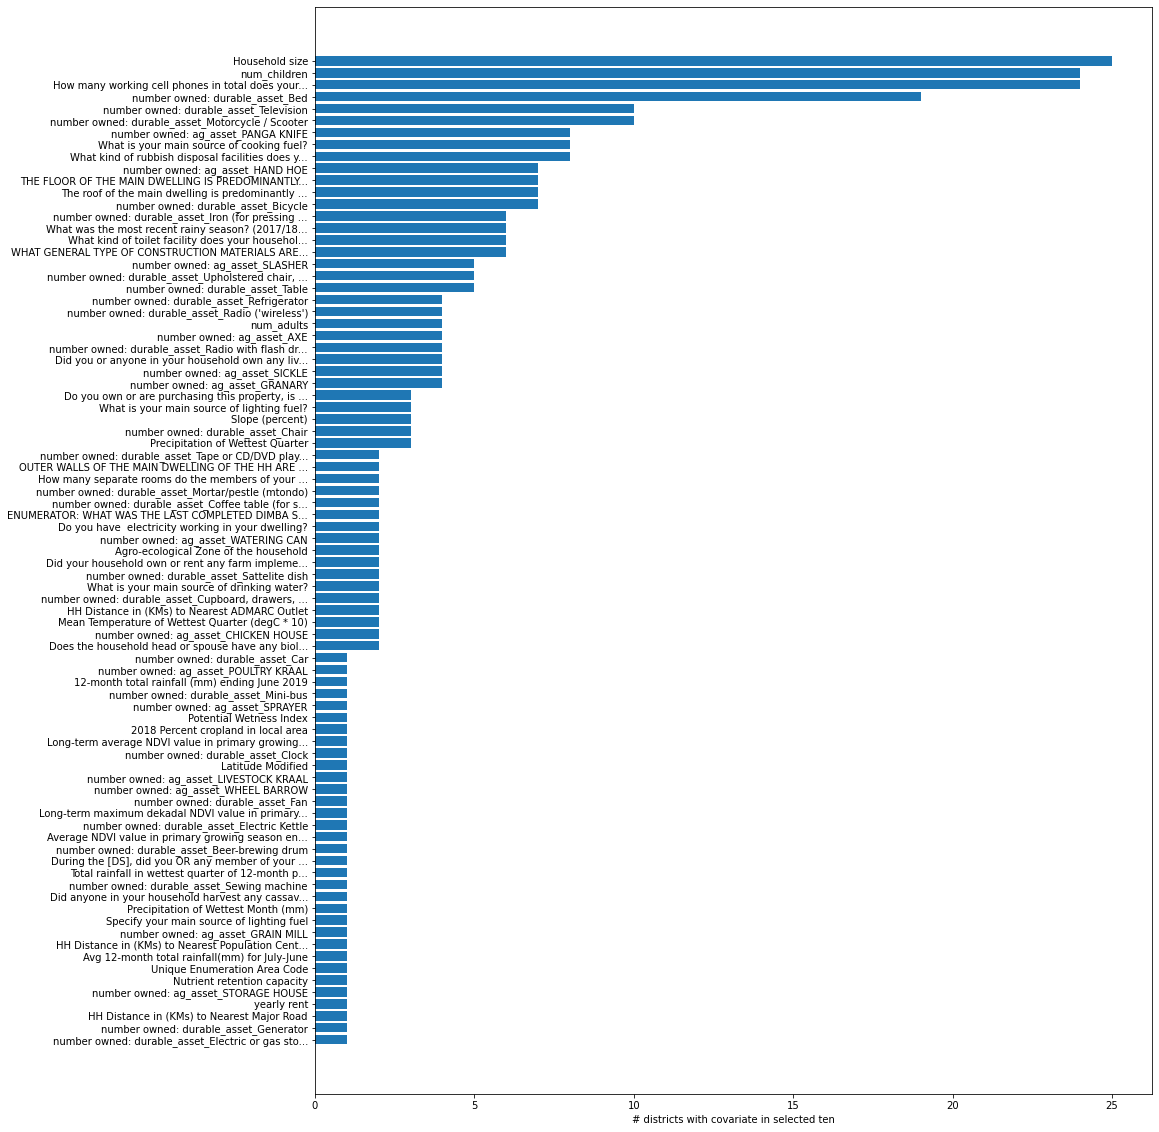

In [36]:
counts.sort_values('count', ascending=True, inplace=True)

def truncate_string(s, max_length):
    if len(s) > max_length:
        return f'{s[:max_length - 3]}...'

    else:
        return s

fig = plt.figure(figsize=(15, 20))

plt.barh(
    counts['description'].apply(lambda s: truncate_string(s, 50)),
    counts['count']
)
# plt.tick_params(axis='x', labelrotation=90)
plt.xlabel('# districts with covariate in selected ten')

## Predict selected covariates using pre-transfer district metrics

In [46]:
simulation_results = pd.read_csv(results_path /'results_for_subnational_analysis' / 'malawi.csv')

simulation_results['total_cost'] = (
    simulation_results['policy_cost_per_capita'] * simulation_results['weight_adjusted_population']
)
simulation_results['initial_poverty_count'] = (
    simulation_results['initial_poverty_rate'] * simulation_results['weight_adjusted_population']
)
simulation_results['post_transfer_poverty_count'] = (
    simulation_results['post_transfer_poverty_rate'] * simulation_results['weight_adjusted_population']
)
simulation_results['initial_total_poverty_gap'] = (
    simulation_results['initial_poverty_gap'] * simulation_results['weight_adjusted_population']
)
simulation_results['post_transfer_total_poverty_gap'] = (
    simulation_results['post_transfer_poverty_gap'] * simulation_results['weight_adjusted_population']
)

simulation_results['poverty_count_reduction'] = (
    simulation_results.initial_poverty_count- simulation_results.post_transfer_poverty_count
)
simulation_results['total_poverty_gap_reduction'] = (
    simulation_results.initial_total_poverty_gap - simulation_results.post_transfer_total_poverty_gap
)

simulation_results['cost_per_poverty_count_reduction'] = (
    simulation_results['total_cost'] / simulation_results.poverty_count_reduction
)
simulation_results['cost_per_total_poverty_gap_reduction'] = (
    simulation_results['total_cost'] / simulation_results.total_poverty_gap_reduction
)

simulation_results['poverty_rate_reduction'] = (
    simulation_results.initial_poverty_rate- simulation_results.post_transfer_poverty_rate
)
simulation_results['poverty_gap_reduction'] = (
    simulation_results.initial_poverty_gap - simulation_results.post_transfer_poverty_gap
)

simulation_results.rename(columns = {'features': 'district'}, inplace=True)

full_country = simulation_results[simulation_results.district == 'full_country']
simulation_results = simulation_results[simulation_results.district != 'full_country']

In [47]:
simulation_results.head(2).district

0      Balaka
1    Blantyre
Name: district, dtype: object

In [71]:
def one_hot_encode_selected_district(row, covariate):
    covariates_selected = district_covariates[row.district].covariate.values
    if covariate in covariates_selected:
        return 1
    return 0

for covariate in counts.covariate:
    simulation_results[covariate] = simulation_results.apply(
        lambda row: one_hot_encode_selected_district(row, covariate),
        axis=1
    )

In [99]:
covariate_scores = dict()
positive_scores = dict()
for covariate in counts.covariate:
    if simulation_results[covariate].sum() < 3:
        covariate_scores[covariate] = np.nan
        continue
    logistic_regression = sklearn_linear_model.LogisticRegression(
        penalty='l2',
        solver='liblinear'
    )
    grid_search = sklearn_model_selection.GridSearchCV(
        estimator=logistic_regression,
        param_grid={'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]},
        scoring='r2',
        cv=sklearn_model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=11)
    )
    grid_search.fit(
        simulation_results[[
            'initial_poverty_rate', 'initial_poverty_gap', 'weight_adjusted_population'
        ]],
        simulation_results[covariate]
    )

    covariate_scores[covariate] = grid_search.best_score_
    if covariate_scores[covariate] > 0:
        positive_scores[covariate] = covariate_scores[covariate]
    

In [101]:
covariate_scores

{'durable_asset_Electric or gas stove; hot plate': nan,
 'durable_asset_Generator': nan,
 'dist_road': nan,
 'yearly_rent': nan,
 'ag_asset_STORAGE HOUSE': nan,
 'sq2': nan,
 'ea_id': nan,
 'anntot_avg': nan,
 'dist_popcenter': nan,
 'ag_asset_GRAIN MILL': nan,
 'hh_f11_oth': nan,
 'af_bio_13_x': nan,
 'hh_x06': nan,
 'durable_asset_Sewing machine': nan,
 'h2019_wetQ': nan,
 'ag_i101b': nan,
 'durable_asset_Beer-brewing drum': nan,
 'h2018_ndvi_avg': nan,
 'durable_asset_Electric Kettle': nan,
 'ndvi_max': nan,
 'durable_asset_Fan': nan,
 'ag_asset_WHEEL BARROW': nan,
 'ag_asset_LIVESTOCK KRAAL': nan,
 'ea_lat_mod': nan,
 'durable_asset_Clock': nan,
 'ndvi_avg': nan,
 'cropshare': nan,
 'twi_mwi': nan,
 'ag_asset_SPRAYER': nan,
 'durable_asset_Mini-bus': nan,
 'h2019_tot': nan,
 'ag_asset_POULTRY KRAAL': nan,
 'durable_asset_Car': nan,
 'hh_o0a': nan,
 'ag_asset_CHICKEN HOUSE': nan,
 'af_bio_8_x': nan,
 'dist_admarc': nan,
 'durable_asset_Cupboard, drawers, bureau': nan,
 'hh_f36': nan